# Lecture des données

In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset = pd.read_csv('train_cap2018.csv')

# Récupération y_train (80 % des données)

Création de l'ensemble de test

In [3]:
from sklearn.model_selection import train_test_split
test_size = 0.2
random_state = 42

In [4]:
train, test = train_test_split(dataset, test_size=test_size, random_state=random_state, shuffle=True, stratify=dataset.loc[:,'level1'])
print(train.shape)
del test

(21848, 60)


In [5]:
y_train = train.iloc[:, -1]
print(y_train.shape)

(21848,)


In [6]:
y_train = y_train.replace({"A1": 0, "A2" : 1, "B1" : 2, "B2" : 3, "C1" : 4, "C2" : 5})

In [7]:
y_train = np.array(y_train.reset_index().iloc[:,1])

# Récupération de X_train (80 % des données)

In [8]:
import tensorflow as tf
import numpy as np
import scipy.sparse as sparse

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
def load(list_files):
    list_files = np.sort(list_files)
    res = []
    for i in range(list_files.shape[0]):
        if i%100==0 and i > 0:
            print("i=", i)
        res.append(sparse.load_npz(file=list_files[i]))
    return np.array(res)

In [10]:
import glob
list_files = np.array(glob.glob("./texts_matrices/*.npz"))
texts_matrices = load(list_files)
test_dense_load = sparse.csr_matrix.todense(texts_matrices[0])
print(test_dense_load)
print(test_dense_load.shape)

i= 100
i= 200
i= 300
i= 400
i= 500
i= 600
i= 700
i= 800
i= 900
i= 1000
i= 1100
i= 1200
i= 1300
i= 1400
i= 1500
i= 1600
i= 1700
i= 1800
i= 1900
i= 2000
i= 2100
i= 2200
i= 2300
i= 2400
i= 2500
i= 2600
i= 2700
i= 2800
i= 2900
i= 3000
i= 3100
i= 3200
i= 3300
i= 3400
i= 3500
i= 3600
i= 3700
i= 3800
i= 3900
i= 4000
i= 4100
i= 4200
i= 4300
i= 4400
i= 4500
i= 4600
i= 4700
i= 4800
i= 4900
i= 5000
i= 5100
i= 5200
i= 5300
i= 5400
i= 5500
i= 5600
i= 5700
i= 5800
i= 5900
i= 6000
i= 6100
i= 6200
i= 6300
i= 6400
i= 6500
i= 6600
i= 6700
i= 6800
i= 6900
i= 7000
i= 7100
i= 7200
i= 7300
i= 7400
i= 7500
i= 7600
i= 7700
i= 7800
i= 7900
i= 8000
i= 8100
i= 8200
i= 8300
i= 8400
i= 8500
i= 8600
i= 8700
i= 8800
i= 8900
i= 9000
i= 9100
i= 9200
i= 9300
i= 9400
i= 9500
i= 9600
i= 9700
i= 9800
i= 9900
i= 10000
i= 10100
i= 10200
i= 10300
i= 10400
i= 10500
i= 10600
i= 10700
i= 10800
i= 10900
i= 11000
i= 11100
i= 11200
i= 11300
i= 11400
i= 11500
i= 11600
i= 11700
i= 11800
i= 11900
i= 12000
i= 12100
i= 12200
i= 12300
i

In [11]:
filename = "./size_texts.npy"
size_texts = np.load(filename)

In [12]:
print(size_texts.shape)
print(size_texts)

(21848,)
[  41.   14.   80. ...,  129.   33.   71.]


In [13]:
print(y_train.shape)

(21848,)


# Séparation de X_train, y_train en deux ensembles: un ensemble d'entrainement et un ensemble de validation.

In [14]:
training_size = 0.7

X_train = texts_matrices[0:int(texts_matrices.shape[0]*training_size)]
y_train_full = y_train
y_train = y_train_full[0:int(texts_matrices.shape[0]*training_size)]
size_texts_train = size_texts[0:int(texts_matrices.shape[0]*training_size)]

X_val = texts_matrices[int(texts_matrices.shape[0]*training_size):]
y_val = y_train_full[int(texts_matrices.shape[0]*training_size):]
size_texts_val = size_texts[int(texts_matrices.shape[0]*training_size):]

Nombre d'éléments par classe dans l'ensemble d'entrainement:

In [15]:
nb_texts_per_classe = np.zeros(6)
for i in range(y_train.shape[0]):
    nb_texts_per_classe[y_train[i]] = nb_texts_per_classe[y_train[i]] + 1
print(nb_texts_per_classe)

[ 6379.  4332.  2968.  1319.   269.    26.]


Nombre d'éléments par classe dans l'ensemble de validation:

In [16]:
print(y_val)
nb_texts_per_classe = np.zeros(6)
for i in range(y_val.shape[0]):
    nb_texts_per_classe[y_val[i]] = nb_texts_per_classe[y_val[i]] + 1
print(nb_texts_per_classe)

[0 2 2 ..., 3 0 1]
[ 2710.  1818.  1338.   551.   124.    14.]


# RNN

# Fonction de création et d'entrainement d'un RNN:

On commence par définir une fonction pour récupérer les données par lot:

In [17]:
def get_next_batch(texts_matrices, iteration, batch_size):
    size_text = texts_matrices[0].shape[0]
    size_word = texts_matrices[0].shape[1]
    #print("(batch_size, size_text, size_word)=", batch_size, size_text, size_word)
    X_batch = np.zeros((batch_size, size_text, size_word)) 
    temp1 = texts_matrices[iteration*batch_size:(iteration+1)*batch_size]
    for i in range(temp1.shape[0]):
        X_batch[i] = np.array(sparse.csr_matrix.todense(temp1[i]))
    return X_batch
#test
temp = get_next_batch(X_train, 0, 3)
temp.shape

(3, 418, 300)

La cellule ci-dessous implémente la fonction d'erreur de la compétition. Malheureusement argmax n'est pas différentiable donc la fonction n'est pas utilisable comme fonction de coût.

In [18]:
costs_tf = tf.constant([[0,1,2,3,4,6],[1,0,1,4,5,8],[3,2,0,3,5,8],[10,7,5,0,2,7],[20,16,12,4,0,8],[44,38,32,19,13,0]])

def cost_tf(inference, y_true):
    y_pred = tf.argmax(inference, axis=1) #pas différentiable...
    confusion = tf.confusion_matrix(y_true, y_pred, num_classes=6)
    res1 = tf.multiply(costs, confusion)
    res2 = tf.reduce_sum(res1)
    res3 = tf.divide(res2, tf.shape(y_true)[0])
    return res3

In [19]:
import tensorflow as tf

def create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_inputs, n_neurons=500, activation=tf.nn.elu, 
                     class_weights=[1, 1, 1, 1, 1, 1], learning_rate=0.001, n_epochs=100, batch_size=200, max_checks_without_progress=3):
    
    tf.reset_default_graph()
    
    X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs], name="X")
    seq_length = tf.placeholder(tf.int32, [None]) #vecteur avec les nombres de mots dans les textes
    y = tf.placeholder(tf.int64, shape=[None], name="y")

    basic_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=activation)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, sequence_length=seq_length, dtype=tf.float32)

    logits = tf.layers.dense(inputs=states, units=n_outputs, name="logits")
    inference = tf.nn.softmax(logits, name="inference")

    with tf.name_scope("loss"):
        #loss = cost(inference, y)

        class_weights_tf = tf.constant(class_weights)
        weights = tf.gather(class_weights_tf, y)
        xentropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits, weights=weights)
        #xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y) #ancienne version (sans poids)
        loss = tf.reduce_mean(xentropy, name="loss")

    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    summary_writer = tf.summary.FileWriter("./summary", tf.get_default_graph())

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    n_batches_per_epoch = X_train.shape[0] // batch_size
    print("Nombre de batchs par epoch =", n_batches_per_epoch)
    
    best_loss = np.infty
    checks_without_progress = 0
    
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            for iteration in range(n_batches_per_epoch):
                if (iteration+1)%10==0:
                    print("Batch n°", iteration+1)
                X_batch = get_next_batch(X_train, iteration, batch_size)
                y_batch = y_train[iteration*batch_size:(iteration+1)*batch_size]

                sess.run(training_op, feed_dict={X: X_batch, y: y_batch, seq_length: size_texts_train[iteration*batch_size:(iteration+1)*batch_size]})

            #acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
            #fonction de coût sur les 5000 premiers textes d'entrainement (pour que ça tienne dans la mémoire vive)
            nb_training_examples = 5000
            loss_train = loss.eval(feed_dict={X: get_next_batch(X_train[0:nb_training_examples], 0, nb_training_examples), y: y_train[0:nb_training_examples], seq_length: size_texts_train[0:nb_training_examples]})
            loss_val = loss.eval(feed_dict={X: get_next_batch(X_val, 0, X_val.shape[0]), y: y_val, seq_length: size_texts_val})
            print(epoch, "Loss training:", loss_train)
            print(epoch, "Loss validation:", loss_val)

            if loss_val < best_loss:
                save_path = saver.save(sess, "./natural_language_classifier.ckpt")
                best_loss = loss_val
                checks_without_progress = 0
            else:
                checks_without_progress += 1
                if checks_without_progress >= MAX_CHECKS_WITHOUT_PROGRESS:
                    print("Early stopping!")
                    break
    return inference, X, seq_length

# Entrainement avec l'ensemble des données d'entrainement

In [20]:
n_steps = X_train[0].shape[0] #taille des textes (rendue fixe)
n_inputs = X_train[0].shape[1] #taille des vecteurs représentant chaque mot
print("Nombre de mots des textes (fixe) =", n_steps)
print("Taille vecteur d'un mot =", n_inputs)
n_neurons = 500
activation = tf.nn.elu
n_outputs = 6
class_weights = [1, 1, 1, 1, 1, 1] #poids de la fonction de coût
learning_rate = 0.001

n_epochs = 100
batch_size = 200

MAX_CHECKS_WITHOUT_PROGRESS = 3

Nombre de mots des textes (fixe) = 418
Taille vecteur d'un mot = 300


In [21]:
inference, X, seq_length = create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_inputs, n_neurons=n_neurons, activation=activation, class_weights=class_weights,
                           learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size, max_checks_without_progress=MAX_CHECKS_WITHOUT_PROGRESS)

Nombre de batchs par epoch = 76
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
0 Loss training: 0.579261
0 Loss validation: 0.601247
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
1 Loss training: 0.465995
1 Loss validation: 0.501533
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
2 Loss training: 0.378154
2 Loss validation: 0.422003
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
3 Loss training: 0.299851
3 Loss validation: 0.346822
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
4 Loss training: 0.236326
4 Loss validation: 0.30278
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
5 Loss training: 0.196709
5 Loss validation: 0.289506
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
6 Loss training: 0.176364
6 Loss validation: 0.287197
Bat

# Mesure de l'erreur

In [18]:
costs = np.array([[0,1,2,3,4,6],[1,0,1,4,5,8],[3,2,0,3,5,8],[10,7,5,0,2,7],[20,16,12,4,0,8],[44,38,32,19,13,0]])
names = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']

In [19]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
from sklearn.metrics import confusion_matrix
print_confusion = True
def cost(y_pred, y_true, normalize=True):
    confusion = confusion_matrix(y_true, y_pred)
    res = (1/y_true.shape[0]) * np.sum(np.multiply(costs, confusion))
    
    if print_confusion:
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_true, y_pred)
        np.set_printoptions(precision=2)

        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, normalize=normalize, title='Normalized confusion matrix')

        plt.show()
    return res

Matrice de confusion + erreur pour l'ensemble de validation

In [21]:
print_confusion = True

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./natural_language_classifier.ckpt")
    res = sess.run(inference, feed_dict={X: get_next_batch(X_val, 0, X_val.shape[0]), seq_length: size_texts_val})
    y_pred = np.argmax(res, axis=1)

print(cost(y_pred, y_val))

ValueError: No variables to save

# Entrainement d'un deuxième réseau mais avec des poids pour la fonction de coût

Les poids sont calculés par rapport à la répartition des effectifs des classes dans l'ensemble des données de la compétition.

In [26]:
class_weights = [1, 1.48, 2.11, 4.86, 23.14, 227.22] #poids de la fonction de coût

In [27]:
inference, X, seq_length = create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_inputs, n_neurons=n_neurons, activation=activation, class_weights=class_weights,
                           learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size, max_checks_without_progress=MAX_CHECKS_WITHOUT_PROGRESS)

Nombre de batchs par epoch = 76
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
0 Loss training: 4.61704
0 Loss validation: 4.74148
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
1 Loss training: 2.85567
1 Loss validation: 3.05106
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
2 Loss training: 2.36514
2 Loss validation: 2.72158
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
3 Loss training: 1.8054
3 Loss validation: 2.59064
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
4 Loss training: 1.54938
4 Loss validation: 2.81633
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
5 Loss training: 1.17063
5 Loss validation: 2.81183
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
6 Loss training: 1.29624
6 Loss validation: 2.9257
Early stopping!


INFO:tensorflow:Restoring parameters from ./natural_language_classifier.ckpt
Normalized confusion matrix
[[ 0.9   0.07  0.02  0.01  0.    0.  ]
 [ 0.1   0.82  0.07  0.01  0.    0.  ]
 [ 0.02  0.15  0.71  0.09  0.01  0.01]
 [ 0.01  0.03  0.23  0.54  0.14  0.05]
 [ 0.    0.03  0.06  0.25  0.59  0.07]
 [ 0.07  0.    0.    0.14  0.64  0.14]]


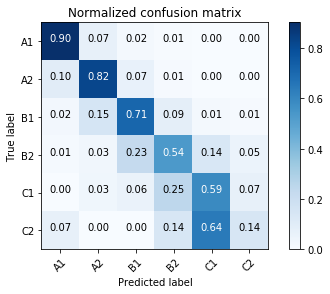

0.533790999237


In [28]:
print_confusion = True

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./natural_language_classifier.ckpt")
    res = sess.run(inference, feed_dict={X: get_next_batch(X_val, 0, X_val.shape[0]), seq_length: size_texts_val})
    y_pred = np.argmax(res, axis=1)

print(cost(y_pred, y_val))

In [29]:
class_weights = [1, 1.48, 2.11, 4.86, 23.14, 50] #poids de la fonction de coût

In [30]:
inference, X, seq_length = create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_inputs, n_neurons=n_neurons, activation=activation, class_weights=class_weights,
                           learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size, max_checks_without_progress=MAX_CHECKS_WITHOUT_PROGRESS)

Nombre de batchs par epoch = 76
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
0 Loss training: 2.15222
0 Loss validation: 2.17147
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
1 Loss training: 1.96239
1 Loss validation: 2.08873
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
2 Loss training: 1.53556
2 Loss validation: 1.76359
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
3 Loss training: 1.33897
3 Loss validation: 1.68242
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
4 Loss training: 1.18654
4 Loss validation: 1.65031
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
5 Loss training: 0.828814
5 Loss validation: 1.55882
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
6 Loss training: 0.695231
6 Loss validation: 1.36169
Batch n° 10
Ba

INFO:tensorflow:Restoring parameters from ./natural_language_classifier.ckpt
Normalized confusion matrix
[[  9.38e-01   3.51e-02   1.51e-02   9.59e-03   2.21e-03   0.00e+00]
 [  5.83e-02   8.62e-01   4.07e-02   3.36e-02   4.40e-03   5.50e-04]
 [  1.57e-02   3.81e-02   7.50e-01   1.64e-01   3.21e-02   7.47e-04]
 [  5.44e-03   1.45e-02   2.18e-02   8.38e-01   1.13e-01   7.26e-03]
 [  0.00e+00   3.23e-02   3.23e-02   1.37e-01   7.82e-01   1.61e-02]
 [  7.14e-02   0.00e+00   0.00e+00   7.14e-02   7.86e-01   7.14e-02]]


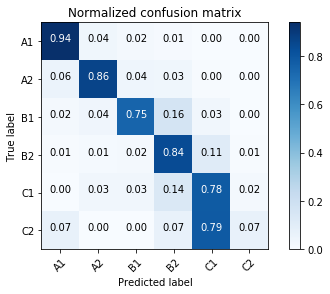

0.380778032037


In [31]:
print_confusion = True

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./natural_language_classifier.ckpt")
    res = sess.run(inference, feed_dict={X: get_next_batch(X_val, 0, X_val.shape[0]), seq_length: size_texts_val})
    y_pred = np.argmax(res, axis=1)

print(cost(y_pred, y_val))

# Dropout

# Problème régression

In [22]:
print(y_train)
print(y_train.shape)

[0 0 2 ..., 2 0 2]
(15293,)


In [23]:
n_steps = X_train[0].shape[0] #taille des textes (rendue fixe)
n_inputs = X_train[0].shape[1] #taille des vecteurs représentant chaque mot
print("Nombre de mots des textes (fixe) =", n_steps)
print("Taille vecteur d'un mot =", n_inputs)
n_neurons = 500
activation = tf.nn.elu
n_outputs = 6
learning_rate = 0.001

n_epochs = 100
batch_size = 200

MAX_CHECKS_WITHOUT_PROGRESS = 3

Nombre de mots des textes (fixe) = 418
Taille vecteur d'un mot = 300


In [24]:
import tensorflow as tf

def create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_inputs, n_neurons=500, activation=tf.nn.elu,
                               learning_rate=0.001, n_epochs=100, batch_size=200, max_checks_without_progress=3):
    
    tf.reset_default_graph()
    
    X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs], name="X")
    seq_length = tf.placeholder(tf.int32, [None]) #vecteur avec les nombres de mots dans les textes
    y = tf.placeholder(tf.int64, shape=[None], name="y")

    basic_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=activation)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, sequence_length=seq_length, dtype=tf.float32)

    mark_temp = tf.layers.dense(inputs=states, units=1, name="mark")
    mark = tf.reshape(mark_temp, [-1])
    inference = tf.round(mark, name="inference")

    with tf.name_scope("loss"):
        loss = tf.losses.mean_squared_error(y, mark)
        
    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

    summary_writer = tf.summary.FileWriter("./summary", tf.get_default_graph())

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    n_batches_per_epoch = X_train.shape[0] // batch_size
    print("Nombre de batchs par epoch =", n_batches_per_epoch)
    
    best_loss = np.infty
    checks_without_progress = 0
    
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            for iteration in range(n_batches_per_epoch):
                if (iteration+1)%10==0:
                    print("Batch n°", iteration+1)
                X_batch = get_next_batch(X_train, iteration, batch_size)
                y_batch = y_train[iteration*batch_size:(iteration+1)*batch_size]

                sess.run(training_op, feed_dict={X: X_batch, y: y_batch, seq_length: size_texts_train[iteration*batch_size:(iteration+1)*batch_size]})

            #fonction de coût sur les 5000 premiers textes d'entrainement (pour que ça tienne dans la mémoire vive)
            nb_training_examples = 5000
            if X_train.shape[0] < nb_training_examples:
                nb_training_examples = X_train.shape[0]
            loss_train = loss.eval(feed_dict={X: get_next_batch(X_train[0:nb_training_examples], 0, nb_training_examples), y: y_train[0:nb_training_examples], seq_length: size_texts_train[0:nb_training_examples]})
            loss_val = loss.eval(feed_dict={X: get_next_batch(X_val, 0, X_val.shape[0]), y: y_val, seq_length: size_texts_val[0:X_val.shape[0]]})
            print(epoch, "Loss training:", loss_train)
            print(epoch, "Loss validation:", loss_val)

            if loss_val < best_loss:
                save_path = saver.save(sess, "./natural_language_classifier.ckpt")
                best_loss = loss_val
                checks_without_progress = 0
            else:
                checks_without_progress += 1
                if checks_without_progress >= MAX_CHECKS_WITHOUT_PROGRESS:
                    print("Early stopping!")
                    break
    return inference, X, seq_length

In [25]:
inference, X, seq_length = create_graph_RNN_and_train(X_train, y_train, X_val, y_val, n_steps, n_inputs, n_neurons=n_neurons, activation=activation,
                           learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size, max_checks_without_progress=MAX_CHECKS_WITHOUT_PROGRESS)

Nombre de batchs par epoch = 76
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
0 Loss training: 0.269612
0 Loss validation: 0.256454
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
1 Loss training: 0.25849
1 Loss validation: 0.264219
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
2 Loss training: 0.210926
2 Loss validation: 0.218407
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
3 Loss training: 0.192101
3 Loss validation: 0.21048
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
4 Loss training: 0.207246
4 Loss validation: 0.235681
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
5 Loss training: 0.194477
5 Loss validation: 0.213712
Batch n° 10
Batch n° 20
Batch n° 30
Batch n° 40
Batch n° 50
Batch n° 60
Batch n° 70
6 Loss training: 0.160126
6 Loss validation: 0.204733
Batc

INFO:tensorflow:Restoring parameters from ./natural_language_classifier.ckpt
Normalized confusion matrix
[[ 0.97  0.03  0.01  0.    0.    0.  ]
 [ 0.06  0.87  0.06  0.    0.    0.  ]
 [ 0.01  0.09  0.84  0.06  0.    0.  ]
 [ 0.    0.02  0.21  0.7   0.06  0.  ]
 [ 0.    0.02  0.2   0.45  0.3   0.02]
 [ 0.07  0.    0.21  0.29  0.43  0.  ]]


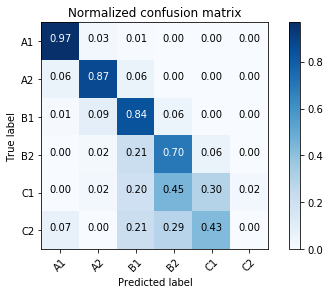

0.3882532418


In [27]:
print_confusion = True

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./natural_language_classifier.ckpt")
    y_pred = sess.run(inference, feed_dict={X: get_next_batch(X_val, 0, X_val.shape[0]), seq_length: size_texts_val})
    #y_pred = np.argmax(res, axis=1)

print(cost(y_pred, y_val))